In [85]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from scipy.linalg import eigh_tridiagonal, LinAlgError, circulant
from math import exp
import multiprocessing
import functools

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

def interaction_matrix(N, alpha, J, normalise = True, dtype = np.float64):
    alternating_signs = 2*(np.arange(1,N) % 2) - 1
    row0 = alternating_signs * np.abs((N/np.pi * np.sin(np.pi * np.arange(1,N, dtype = dtype)/N)) ** (-alpha))
    row0 = np.concatenate([[0,], row0])# put the first 0 in by hand
    if normalise and (N > 1): row0 = row0 / np.sum(np.abs(row0))
    row0 = J * row0
    return circulant(row0)

def solve_H(state, mu, beta, U, J_matrix, t):
    muf = muc = mu
    if state.size == 1:
        evals = np.array([np.sum(U*(state - 1/2) - muc)])
        evecs = np.array([1,])
        Ff = np.sum(- U/2*(state - 1/2) - muf*state)
        Fc = - 1/beta * np.log(1 + np.exp(- beta * evals[0]))
    else:
        evals, evecs = eigh_tridiagonal(d = U*(state - 1/2) - muc, e =-t*np.ones(state.shape[0] - 1), lapack_driver = 'stev')
        Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state) + (state - 1/2).T @ J_matrix @ (state - 1/2)
        Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))
    
    return Ff, Fc, evals, evecs

        

def FK_mcmc(
    state,            
    N_steps = 100, N_burn_in = 10,
    mu = 0, beta = 0.1, J=1, alpha=1.5, U = 1, t=1,
    logger = None, normalise = True,
    ):
    
    N_sites = state.shape[0]
    random_numbers = np.random.rand(N_steps + N_burn_in, N_sites)
    J_matrix = interaction_matrix(N_sites, 1.5, J, normalise = normalise, dtype = np.float64)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    old_F = Ff + Fc
    if logger == None: logger = DataLogger()
    logger.start(N_steps, N_sites)
    accepted = 0
    
    for i in range(N_steps + N_burn_in):
        for site in range(N_sites):
            state[site] = 1 - state[site]
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t=t)
            dF = (Ff+Fc) - old_F

            #if the move is rejected flip the site back and pretend nothing happened
            if dF > 0 and exp(- beta * dF) < random_numbers[i, site]:
                state[site] = 1 - state[site]
            else:
                old_F = Ff+Fc
                accepted += 1
    
        if i >= N_burn_in:
                j = i - N_burn_in
                logger.update(j, Ff, Fc, state, evals, evecs,  mu, beta, J_matrix)

    p_acc = accepted / N_sites / (N_steps + N_burn_in)
    if p_acc < 0.2 or p_acc > 0.5: print(f'Warning, p_acc = {p_acc}, mu = {mu}, beta = {beta}, J = {J}')
    logger.p_acc = p_acc
    #print(f'acceptance probability: {accepted / N_sites / (N_steps + N_burn_in)}, mu = {mu}')
    return logger.return_vals()

def FK_mcmc_auto_reflect(
    state,            
    N_steps = 100, N_burn_in = 10,
    mu = 0, beta = 0.1, J=1, alpha=1.5, U = 1, t=1,
    logger = None, normalise = True,
    ):
    
    assert(mu == 0)
    N_sites = state.shape[0]
    random_numbers = np.random.rand(N_steps + N_burn_in, N_sites)
    J_matrix = interaction_matrix(N_sites, 1.5, J, normalise = normalise, dtype = np.float64)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    old_F = Ff + Fc
    if logger == None: logger = DataLogger()
    logger.start(N_steps*2, N_sites)
    
    accepted = 0
    for i in range(N_steps + N_burn_in):
        for site in range(N_sites):
            state[site] = 1 if state[site] == 0 else 0
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
            dF = (Ff+Fc) - old_F
            
            #if the move is rejected flip the site back and pretend nothing happened
            if dF > 0 and exp(- beta * dF) < random_numbers[i, site]:
                state[site] = 1 if state[site] == 0 else 0
            else:
                accepted += 1
                old_F = Ff+Fc
    
        if i >= N_burn_in:
                j = i - N_burn_in
                logger.update(2*j, Ff, Fc, state, evals, evecs,  mu, beta, J_matrix)
                
                Ff, Fc, evals, evecs = solve_H(1-state, mu, beta, U, J_matrix, t)
                logger.update(2*j+1, Ff, Fc, 1-state, evals, evecs,  mu, beta, J_matrix)

    p_acc = accepted / N_sites / (N_steps + N_burn_in)
    if p_acc < 0.1: print(f'Warning, p_acc = {p_acc}, mu = {mu}, beta = {beta}, J = {J}')
    logger.p_acc = p_acc
    return logger.return_vals()

def FK_mcmc_random_pair(
    state,            
    N_steps = 100, N_burn_in = 10,
    mu = 0, beta = 0.1, J=1, alpha=1.5, U = 1, t=1,
    logger = None, normalise = True,
    ):
    
    N_sites = state.shape[0]
    random_numbers = np.random.rand(N_steps + N_burn_in, N_sites)
    J_matrix = interaction_matrix(N_sites, 1.5, J, normalise = normalise, dtype = np.float64)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    old_F = Ff + Fc
    if logger == None: logger = DataLogger()
    logger.start(N_steps, N_sites)
    accepted = 0
    
    for i in range(N_steps + N_burn_in):
        for site in range(N_sites):
            site1, site2 = np.random.randint(N_sites, size=(2))
            state[site1] = 1 - state[site1]
            state[site2] = 1 - state[site2]
            
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t=t)
            dF = (Ff+Fc) - old_F

            #if the move is rejected flip the site back and pretend nothing happened
            if dF > 0 and exp(- beta * dF) < random_numbers[i, site]:
                state[site1] = 1 - state[site1]
                state[site2] = 1 - state[site2]
            else:
                old_F = Ff+Fc
                accepted += 1
    
        if i >= N_burn_in:
                j = i - N_burn_in
                logger.update(j, Ff, Fc, state, evals, evecs,  mu, beta, J_matrix)

    print(f'acceptance probability: {accepted / N_sites / (N_steps + N_burn_in)}, mu = {mu}')
    return logger.return_vals()

##a datalogger to compute the cumulants of magnetisation
class Magnetisation_cumulants(object):
    def __init__(self, N_cumulants = 5):
        self.N_cumulants = N_cumulants
    
    def start(self, N_steps, N_sites):
        self.N_sites = N_sites
        self.A = 2*(np.arange(system_size) % 2) - 1
        self.powers = np.arange(self.N_cumulants)
        self.Mf_moments = np.zeros((N_steps, self.N_cumulants), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.Mf_moments[j] = np.sum(2*(state - 1/2) * self.A / self.N_sites)**self.powers
    
    def return_vals(self):
        moments, dmoments = np.mean(self.Mf_moments, axis = 0), scipy.stats.sem(self.Mf_moments, axis = 0)
        central_moments = convert_to_central_moments(moments)
        return moments, central_moments

class Magnetisation_squared(object):
    def start(self, N_steps, N_sites):
        self.A = 2*(np.arange(system_size) % 2) - 1
        self.M2f = np.zeros((N_steps), dtype = np.float64).T
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.M2f[j] = np.sum((state - 1/2) * self.A)**2
    
    def return_vals(self):
        return np.mean(self.M2f), scipy.stats.sem(self.M2f)
    
class Density(object):
    def start(self, N_steps, N_sites):
        self.N = np.zeros((N_steps), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.N[j] = np.sum(state) + np.sum(1/(1 + np.exp(beta * evals)))
    
    def return_vals(self):
        return np.mean(self.N), scipy.stats.sem(self.N)
    
class NfNc(object):
    def start(self, N_steps, N_sites):
        self.N_sites = N_sites
        self.Nf = np.zeros((N_steps), dtype = np.float64)
        self.Nc = np.zeros((N_steps), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.Nf[j] = np.sum(state) / self.N_sites
        self.Nc[j] = np.sum(1/(1 + np.exp(beta * evals))) / self.N_sites
    
    def return_vals(self):
        Nf, Nc, dNf, dNc = np.mean(self.Nf), np.mean(self.Nc), scipy.stats.sem(self.Nf), scipy.stats.sem(self.Nc)
        return Nf, Nc, dNf, dNc

def moments_about_zero(data, n):
    powers = np.arange(0,5)
    N = data.shape[0]
    return (data[None, :]**powers[:, None]).sum(axis = -1) / N
    
    
def moments_about_mean(data, n):
    powers = np.arange(0,5)
    mean = np.average(data)
    N = data.shape[0]
    z = (data[None, :]-mean)
    return (z**powers[:, None]).sum(axis = -1) / N

def convert_to_central_moments(non_central_moments):
    mean = non_central_moments[1]
    N = non_central_moments.shape[0]
    n = np.arange(N)[:, None] * np.ones((N,N)) # n changes on the 0th axis
    i = np.arange(N)[None, :] * np.ones((N,N))# i changes on the 1st axis

    m = np.where((n-i) >= 0, n-i, 1)
    return (scipy.special.binom(n, i) * non_central_moments[None, :] * (-mean)**m).sum(axis = 1)

def index_histogram(bin_edges, data):
    "perform a similar function to np.histogram except also return the indices that sort the data into bins"
    
    indices = np.searchsorted(bin_edges, data)
    hist = np.bincount(indices, minlength = bin_edges.shape[0] + 1)
    return hist[1:-1], bin_edges, indices

In [75]:
#a catch all datalogger
class DataLogger(object):
    def __init__(self, N_cumulants = 5):
        self.N_cumulants = N_cumulants
        
    def start(self, N_steps, N_sites):
        self.N_sites = N_sites
        self.N_steps = N_steps
        self.A = 2*(np.arange(N_sites) % 2) - 1
        self.Fc, self.Ff, self.Nf, self.Nc = np.zeros((N_steps,4), dtype = np.float64).T ##The way this is laid out in memory may affect the speed
        self.state, self.eigenvals = np.zeros((2,N_steps,N_sites), dtype = np.float64)
        self.eigenvecs = np.zeros((N_steps,N_sites,N_sites), dtype = np.float64)
        self.powers = np.arange(self.N_cumulants)
        self.Mf_moments = np.zeros((self.N_cumulants, N_steps), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.Ff[j] = Ff
        self.Fc[j] = Fc
        self.Nf[j] = np.sum(state) / self.N_sites
        self.Nc[j] = np.sum(1/(1 + np.exp(beta * evals))) / self.N_sites
        self.Mf_moments[:, j] = np.sum(2*(state - 1/2) * self.A / self.N_sites)**self.powers
        self.state[j] = state
        self.eigenvals[j] = evals

    
    def return_vals(self):
        #self.Mf, self.dMf = np.mean(self.Mf_moments, axis = 0), scipy.stats.sem(self.Mf_moments, axis = 0)
        self.cMf_moments = (self.Mf_moments[1] - np.mean(self.Mf_moments[1]))[None, :] ** self.powers[:, None]
        return self

N_steps = 1000
N = 50
beta = 1/10
U = 0
J = 5
mu = 4
t = 1
alpha = 1.5
state = np.zeros(N, dtype = np.float64)
N_steps = 100
N_burn_in = 0

#log = FK_mcmc_random_pair(
log = FK_mcmc(
    state,            
    N_steps = N_steps, N_burn_in = N_burn_in,
    mu = mu, beta = beta, J = J, alpha=alpha, U = U, t=t,
    logger = DataLogger(), normalise = True,
    )
print(f'mcmc step acceptance probability = {log.p_acc*100}%')
print('done!')

mcmc step acceptance probability = 81.34%
done!


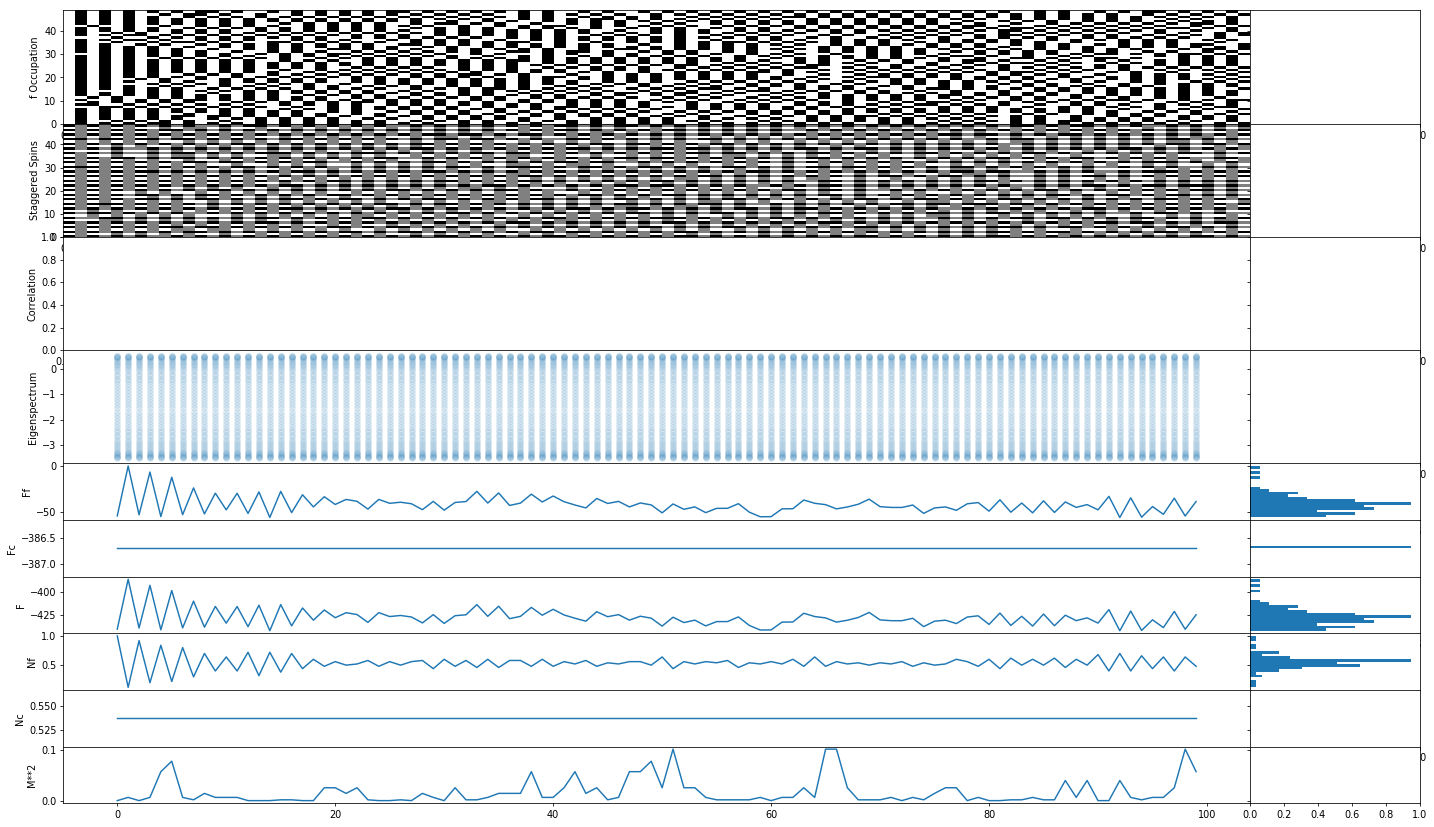

In [9]:
steps = np.arange(log.N_steps)
sites = np.arange(log.N_sites)

f, axes = plt.subplots(10,2, figsize = (25,15), sharey = 'row', gridspec_kw = dict(height_ratios=[2,2,2,2,1,1,1,1,1,1], width_ratios=[7, 1],wspace=0, hspace=0))

axs, axs1 = axes.T
observables = [_, _, _, _, log.Ff, log.Fc, log.Ff + log.Fc, log.Nf, log.Nc, log.Mf_moments[2], log.cMf_moments[2]]
observable_ylabels = ['f Occupation', 'Staggered Spins', 'Correlation', 'Eigenspectrum',
                      'Ff', 'Fc', 'F', 'Nf', 'Nc', 'M**2', '(M-M_bar)**2']

axs[0].pcolor(steps, sites, log.state.T, cmap = 'gray', vmin = 0, vmax = 1)
axs[1].pcolor(steps, sites, (log.state * log.A).T, cmap = 'gray', vmin = -1, vmax = 1)
#axs[2].pcolor(steps, sites[:correlation.shape[-1]], 1-correlation.T, cmap = 'gray', vmin = 0, vmax = 1)

x = np.reshape(steps[:, np.newaxis] * np.ones_like(log.eigenvals), [-1,])
y = np.reshape(log.eigenvals, [-1])
axs[3].scatter(x, y, alpha = 0.1,)

for ax,observable in list(zip(axs,observables))[4:]: ax.plot(steps, observable)

#axs1[0].plot(r.states.mean(axis=0), sites)
#axs1[1].plot(r.ts.mean(axis=0), sites)
#axs1[2].plot(correlation.mean(axis=0), sites[:correlation.shape[-1]])


hist_kwargs = dict(orientation='horizontal', bins = 20, density = True)
#axs1[3].plot(r.q_energy_histogram / np.sum(r.q_energy_histogram), r.q_energy_histogram_bins[:-1])

for ax,observable in list(zip(axs1,observables))[4:8]: ax.hist(observable, **hist_kwargs)

for ylabel, ax in zip(observable_ylabels, axs): ax.set(ylabel=ylabel)
axs[5].set(xlabel = 'MC Step (One trial per site per step)');

p_acc = 0.8658571428571429


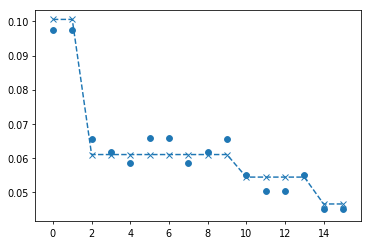

In [86]:
def states_to_numbers(states):
    return np.int64(np.sum(states * 2**np.arange(states.shape[1])[None, ::-1], axis = 1))
def number_to_state(number):
    return np.unpackbits(np.array([number], dtype = np.uint8))

def enumerate_states(system_size, mu, beta, U, J, t = 1, alpha = 1.5, normalise = True):
    assert(system_size <= 8)
    Z = 0
    Nf = Nc = Mf = M2f = 0
    muf = muc = mu
    A = 2*(np.arange(system_size) % 2) - 1
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = normalise, dtype = np.float64)
    
    state_labels = np.arange(2**system_size, dtype = np.uint8)
    states = np.unpackbits(state_labels).reshape(-1,8)[:, system_size:]
    Fcs, Ffs = np.zeros(shape=(2, 2**system_size), dtype = np.float64)
    
    for i, state in zip(state_labels, states):
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
        Fcs[i], Ffs[i] = Fc, Ff
        
        Boltz_factor = np.exp(- beta * (Ff + Fc))
        #Z += Boltz_factor
        #Nf += np.sum(state) / system_size
        #Nc += np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor / system_size
        #Mf += np.sum(2*(state - 1/2) * A) * Boltz_factor / system_size
        #M2f += np.sum(2*(state - 1/2) * A / system_size)**2 * Boltz_factor
    
    ix = np.argsort(Fcs + Ffs)
    return ix, state_labels[ix], states[ix], Fcs[ix], Ffs[ix]

##compare to montecarlo
N = 4
N_steps = 300
beta = 1/10
U = 0
J = 5
mu = 0
t = 1
alpha = 1.5
state = np.zeros(N, dtype = np.float64)
N_steps = 10000
N_burn_in = 500

#log = FK_mcmc_random_pair(
log = FK_mcmc_auto_reflect(
    state=np.zeros(N),            
    N_steps = N_steps, N_burn_in = N_burn_in,
    mu = mu, beta = beta, J = J, alpha=alpha, U = U, t=t,
    logger = DataLogger(), normalise = True,
    )

mc_state_labels = states_to_numbers(log.state)
mc_label_count = np.bincount(mc_state_labels, minlength = 2**N)
mc_energies = log.Ff + log.Fc
print(f'p_acc = {log.p_acc}')

ix, state_labels, states, Fcs, Ffs = enumerate_states(N, mu, beta, U, J, t, alpha, normalise = True)
Boltz_factors = np.exp(- beta * (Ffs + Fcs))
Ps = Boltz_factors / np.sum(Boltz_factors)

plt.plot(np.arange(2**N), Ps, '--x')
plt.scatter(np.arange(2**N), mc_label_count[ix]/np.sum(mc_label_count))


In [ ]:
system_size = 200; alpha = 1.5; J = 1; beta = 1; U = 1; t = 1; mu = 0;
J_matrix = interaction_matrix(system_size, alpha, J, normalise = True, dtype = np.float64)
f, axs = plt.subplots(1,2, figsize = (10,5))
bins = 50

#all zeros
state = np.zeros(system_size)
Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
axs[0].hist(evals, bins = bins)
axs[0].text(0.5, 0.6, "No f electrons", transform=axs[0].transAxes, horizontalalignment='center', verticalalignment='center')

#CDW
state = np.arange(system_size) % 2
Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
axs[1].hist(evals, bins = bins);
axs[1].text(0.5, 0.6, "Perfect CDW f electrons", transform=axs[1].transAxes, horizontalalignment='center', verticalalignment='center')
print(f'CDW: Ff = {Ff}, Fc = {Fc}')

### Single site by hand:
This uses the analytic expression calculated by hand for a single site/non-interacting limit.

In [ ]:
#calculated this by hand
def rho_in_single_site_limit(mu, beta, U):
    Z = np.exp(-beta*(U /4)) + 2*np.exp(-beta*(-U /4 - mu)) + np.exp(-beta*(U /4 - 2*mu))  
    return 2*(np.exp(-beta*(-U /4 - mu)) + np.exp(-beta*(U /4 - 2*mu))) / Z

#A slightly more automatic way to do it
def non_symmetric_version(u, beta, U):
    Z = 0
    Nf = 0
    Nc = 0
    for nf in [0,1]:
        Ff = -U/2*(nf - 1/2) - mu*nf
        Hc = U*(nf - 1/2) - mu #Hc only has one energy level in the single site limit
        Fc = -1/beta * np.log(1 + np.exp(-beta*Hc))
        boltzman_factor = np.exp(-beta * (Fc + Ff))
        Z += boltzman_factor
        Nf += nf * boltzman_factor
        Nc += 1/(1 + np.exp(beta * Hc)) * boltzman_factor
    return Nf / Z, Nc / Z

mu = np.linspace(-2,2,100)
U = 1
f, (ax, axf,axc) = plt.subplots(1,3, figsize = (15,5))



for beta in [5, 10, 100]:
    Nf, Nc = non_symmetric_version(mu, beta=beta, U=U)
    
    ax.plot(mu, Nf + Nc, label = f'beta = {beta}')
    
    ax.set(ylabel = '$<n_f + n_c>$', xlabel = '$\mu$',
           xticks = [-1/2,0, 1/2], xticklabels = ['$-U/2$', 0, '$U/2$'], yticks = [0,1,2])
ax.legend()

## Directly evaluating the partition function for multiple sites
This iterates over all classical states and then solves the hamiltonian to evavluate the full partition function directly.

The first plot turns on hopping t with the long range interaction J set to 0.

In [ ]:
def direct_compute_observables(system_size, mu, beta, U, J_matrix, t, max_BF, A, state):
    state = np.array(state)
    muf = muc = mu
    if system_size > 1:
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    elif system_size == 1:
        evals = np.array([U*(state - 1/2)]) - muc
        Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
        Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))    

    Boltz_factor = np.exp(- beta * (Ff + Fc))
    Nf = np.sum(state) * Boltz_factor / system_size
    Nc = np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor / system_size
    Mf = np.sum(2*(state - 1/2) * A) * Boltz_factor / system_size
    M2f = np.sum(2*(state - 1/2) * A / system_size)**2 * Boltz_factor
    
    return Boltz_factor, Nf, Nc, Mf, M2f

def direct_parrallel(system_size, mu, beta, U, J, t = 1, alpha = 1.5, pool = None, normalise = True):
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = normalise, dtype = np.float64)
    A = 2*(np.arange(system_size) % 2) - 1
    
    ##check the ground state energy
    state = (np.arange(system_size) % 2)
    muf = muc = mu
    if system_size > 1:
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    elif system_size == 1:
        evals = np.array([U*(state - 1/2)]) - muc
        Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
        Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))  
    max_BF = - beta * (Ff + Fc)
    #print(f'max_BF = {max_BF}')
    
    compute = functools.partial(direct_compute_observables, system_size, mu, beta, U, J_matrix, t, max_BF, A)
    Z, Nf, Nc, Mf, M2f = np.sum([compute(state) for state in product((0,1), repeat = system_size)], axis = 0)
    Nf, Nc, Mf, M2f =  Nf/Z, Nc/Z, Mf/Z, M2f/Z

    return Nf/Z, Nc/Z, Mf/Z, M2f/Z
    

def direct(system_size, mu, beta, U, J, t = 1, alpha = 1.5, normalise = True):
    Z = 0
    Nf = Nc = Mf = M2f = 0
    muf = muc = mu
    A = 2*(np.arange(system_size) % 2) - 1
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = normalise, dtype = np.float64)
    
    for state in product((0,1), repeat = system_size):
        state = np.array(state)
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
        Boltz_factor = np.exp(- beta * (Ff + Fc))
        Z += Boltz_factor
        Nf += np.sum(state) * Boltz_factor / system_size
        Nc += np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor / system_size
        Mf += np.sum(2*(state - 1/2) * A) * Boltz_factor / system_size
        M2f += np.sum(2*(state - 1/2) * A / system_size)**2 * Boltz_factor
        
    return Nf / Z, Nc / Z, Mf / Z, M2f / Z

def binder_compute_observables(system_size, mu, beta, U, J_matrix, t, max_BF, A, powers, state):
        state = np.array(state)
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
        lnP = - beta * (Ff + Fc) - max_BF + 650
        if(lnP > 700): print(f'- beta * (Ff + Fc) too large! : {- beta * (Ff + Fc)}')
        
        Boltz_factor = np.exp(lnP)
        Mf_moments = Boltz_factor * (np.sum(2*(state - 1/2) * A)/system_size)**powers
        return np.concatenate([[Boltz_factor,], Mf_moments])

def binder(system_size, mu, beta, U, J, t = 1, alpha = 1.5, n_cumulants = 5, normalise = True):
    Z = 0
    Nf = Nc = Mf = M2f = 0
    muf = muc = mu
    A = 2*(np.arange(system_size) % 2) - 1
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = normalise, dtype = np.float64)
    
    powers = np.arange(n_cumulants)
    Mf_moments = np.zeros(powers.shape[0], dtype = np.float64)

    ##check the ground state energy
    state = (np.arange(system_size) % 2)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    max_BF = - beta * (Ff + Fc)
    #print(f'max_BF = {max_BF}')
    
    for i,state in enumerate(product((0,1), repeat = system_size)):
        state = np.array(state)
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)

        lnP = - beta * (Ff + Fc) - max_BF + 650
        if(lnP > 700): print(f'- beta * (Ff + Fc) too large! : {- beta * (Ff + Fc)}')
        Boltz_factor = np.exp(lnP)
        Z += Boltz_factor
        Mf_moments += Boltz_factor * (np.sum(2*(state - 1/2) * A)/system_size)**powers

    #print(Mf_moments, Z)
    Mf_moments = Mf_moments / Z
    Mf_central_moments = convert_to_central_moments(Mf_moments)
    return Mf_moments, Mf_central_moments

def compute_observables(system_size, mu, beta, U, J_matrix, t, state):
    eigenval_bins = np.linspace(-5, 5, 70 + 1)
    state = np.array(state)
    muf = muc = mu
    if system_size > 1:
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    elif system_size == 1:
        evals = np.array([U*(state - 1/2)]) - muc
        Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
        Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))    

    Boltz_factor = np.exp(- beta * (Ff + Fc))
    Z = Boltz_factor
    Nf = np.sum(state) * Boltz_factor
    Nc = np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor

    IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)

    #these are the indices corresponding to the energy bin that each energy and IPR should go into
    hist, _, indices = index_histogram(eigenval_bins, evals)
    this_IPR_hist = np.bincount(indices, weights=IPRs, minlength = eigenval_bins.shape[0] + 1)[1:-1]

    eigenval_hist = hist * Boltz_factor
    IPR_hist = this_IPR_hist * Boltz_factor #/ np.where(hist != 0, hist, 1)

    return np.concatenate([[Z,], [Nf,], [Nc,], eigenval_hist, IPR_hist])

def direct_spectrum(system_size, mu, beta, U, J, t = 1, pool = None):
    eigenval_bins = np.linspace(-5, 5, 70 + 1)
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = True, dtype = np.float64)
    
    compute = functools.partial(compute_observables, system_size, mu, beta, U, J_matrix, t)
    
    if pool:
            packed_result = np.sum(pool.map(compute, product((0,1), repeat = system_size)), axis = 0)
    else:
        packed_result = np.sum(pool.map(compute, product((0,1), repeat = system_size)), axis = 0)
    
    Z, Nf, Nc, *rest = packed_result
    eigenval_hist, IPR_hist = rest[:eigenval_bins.shape[0]-1], rest[eigenval_bins.shape[0]-1:] 
        
    eigenval_hist = eigenval_hist / np.sum(eigenval_hist)
    return Nf / Z, Nc / Z, eigenval_hist, eigenval_bins, IPR_hist / Z / np.where(eigenval_hist != 0, eigenval_hist, 1)

def binder_compute_observables(system_size, mu, beta, U, J_matrix, t, max_BF, A, powers, state):
        state = np.array(state)
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
        lnP = - beta * (Ff + Fc) - max_BF + 650
        if(lnP > 700): print(f'- beta * (Ff + Fc) too large! : {- beta * (Ff + Fc)}')
        
        Boltz_factor = np.exp(lnP)
        Mf_moments = Boltz_factor * (np.sum(2*(state - 1/2) * A)/system_size)**powers
        return np.concatenate([[Boltz_factor,], Mf_moments])

def binder_parrallel(system_size, mu, beta, U, J, t = 1, alpha = 1.5, pool = None, normalise = True):
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = normalise, dtype = np.float64)
    A = 2*(np.arange(system_size) % 2) - 1
    powers = np.arange(n_cumulants)
    
    ##check the ground state energy
    state = (np.arange(system_size) % 2)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    max_BF = - beta * (Ff + Fc)
    #print(f'max_BF = {max_BF}')
    
    compute = functools.partial(binder_compute_observables, system_size, mu, beta, U, J_matrix, t, max_BF, A, powers)
    
    if pool != None:
            packed_result = np.sum(pool.map(compute, product((0,1), repeat = system_size), chunksize = 4), axis = 0)
    else:
        packed_result = np.sum([compute(state) for state in product((0,1), repeat = system_size)], axis = 0)

    Z, *Mf_moments = packed_result
    Mf_moments = Mf_moments / Z
    Mf_central_moments = convert_to_central_moments(Mf_moments)
    return Mf_moments, Mf_central_moments



In [ ]:
#%%time
beta = 1/5
U = 1
Js = [1,5]
mu = np.linspace(-5,5,30)
Ns = [1,2,4,6]
t = 1
alpha = 1.5
N_steps = 500
N_burn_in = 100
normalise = True

def compute(m, **kwargs):
    return FK_mcmc(mu=m,**kwargs)

data = np.zeros(shape = (len(Js), len(Ns), 6, len(mu)))

with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for Jslice, J in zip(data, Js):
        for Nslice, N in zip(Jslice, Ns):
            print(J, N)
            if N < 16:
                Nf, Nc, _, _ = np.array([direct(system_size=N, mu=m,
                                                          beta=beta, U=U, J=J, t=t,
                                                          normalise = normalise) for m in mu]).T
            else:
                Nf, Nc = np.zeros((2,mu.shape[0]))

            curried = functools.partial(compute, state=np.random.choice(a = [0,1], size = N), 
                    N_steps = N_steps, N_burn_in = N_burn_in, 
                    J=J, alpha=alpha, U=U, t=t,
                    logger=NfNc(), normalise = normalise)
                
            mc_Nf, mc_Nc, mc_dNf, mc_dNc = np.array(pool.map(curried, mu)).T
            
            np.copyto(Nslice, np.array([Nf, Nc, mc_Nf, mc_Nc, mc_dNf, mc_dNc]))

np.savez('./pickled_data/density_vs_mu.npz', 
         beta=beta, U=U, t=t, mu=mu, Ns=Ns, Js=Js, alpha=alpha, N_steps = N_steps, N_burn_in=N_burn_in,
        data=data, normalise=normalise,
        )
print('done')

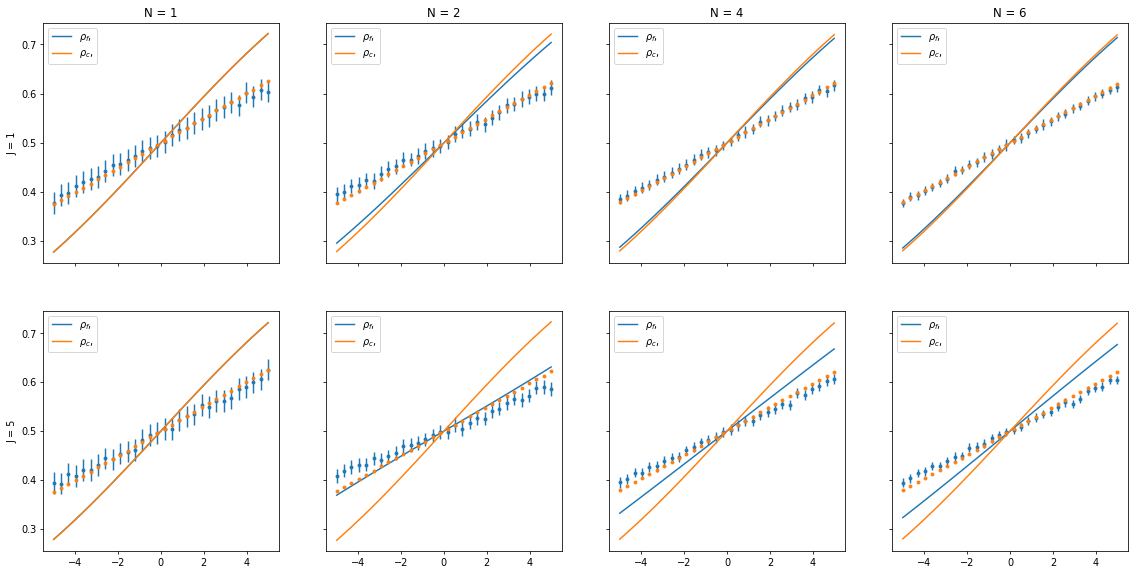

In [87]:
#%%time
data = np.load('./pickled_data/density_vs_mu.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Ns),figsize = (len(Ns)*5,len(Js)*5), sharex = 'col', sharey = 'row')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for row, Jslice, J in zip(axes, data, Js):
    for ax, Nslice, N in zip(row, Jslice, Ns):
        Nf, Nc, mc_Nf, mc_Nc, mc_dNf, mc_dNc = Nslice

        Nt = (Nf + Nc) / 2
        
        #ax.plot(mu, Nt, label = r'$\frac{1}{2}(\rho_F + \rho_c)$,' +f' (N = {N})')
        
        ax.plot(mu, Nf, label = r'$\rho_f$,', color = colors[0])
        ax.plot(mu, Nc, label = r'$\rho_c$,', color = colors[1])
        
        ax.errorbar(mu, mc_Nf, yerr = mc_dNf, fmt = '.', color = colors[0])
        ax.errorbar(mu, mc_Nc, yerr = mc_dNc, fmt = '.', color = colors[1])
        ax.legend()
        
for ax,N in zip(axes[0],Ns): ax.set(title = f'N = {N}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 

This plot turns on J with t=1 and U = 1

In [ ]:
beta = 10
U = 1
Js = [0, 0.1, 1]
mu = np.linspace(-3,3,100)
Ns = [1,2,3,4,6]
t = 0

f, axes = plt.subplots(len(Js),len(Ns),figsize = (len(Ns)*5,len(Js)*5), sharex = 'col', sharey = 'row')

for row, J in zip(axes, Js):
    for ax, N in zip(row, Ns):
        Nf, Nc, _, _ = np.array([direct(N, m, beta, U, J=J, t=t) for m in mu]).T
        Nt = (Nf + Nc)
        ax.plot(mu, Nt/(2*N), label = r'$\frac{1}{2}(\rho_F + \rho_c)$,' +f' (N = {N})')
        ax.plot(mu, Nf/N, label = r'$\rho_f$,')
        ax.plot(mu, Nc/N, label = r'$\rho_c$,')
        ax.legend()
        
for ax,N in zip(axes[0],Ns): ax.set(title = f'N = {N}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'mu') 

## Looking at the magnetisation squared

In [ ]:
%%time
T = np.linspace(0.03, 2, 20)
beta = 1/T
mu = np.linspace(-3,3,100)
Ns = [4,6,8]#[6,7,8,9,10,11,12]
Us = [0,0.1,1]
Js = [0, 0.1, 1, 5]
t = 1

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row')

for row, J in zip(axes, Js):
    for ax, U in zip(row, Us):
        for system_size in Ns:
            Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = U, J = J, t = 1) for b in beta]).T
            ax.plot(T, M2f / system_size**2, label = f'N = {system_size}')
        
        ax.legend()

f.suptitle('Magnetisation squared against temperature')
for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T') 

## Looking at the Binder Cumulant

In [ ]:
%%time
n_cumulants = 5
T = np.linspace(0.05, 5, 30)
beta = 1/T
Ns = [8,12,16,20]
Us = [0,1,10]
Js = [0, 0.1, 1, 5]
t = 1
alpha = 1.5

binder_cumulants = np.ones(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for slice1, J in zip(binder_cumulants, Js):
        for slice2, U in zip(slice1, Us):
            for slice3, system_size in zip(slice2, Ns):
                print(system_size, U, J)
                result = np.array([binder_parrallel(system_size = system_size, mu = 0, beta = b, U = U, J = J, t = t, alpha = alpha, pool=pool) for b in beta])
                np.copyto(slice3, np.einsum('ijk->jki',result))

np.savez('./pickled_data/binder_cumulants_direct_no_normalise.npz', 
         T=T, Ns=Ns, Us=Us, Js = Js, n_cumulants=n_cumulants, t=t, alpha = alpha, beta = beta,
         binder_cumulants=binder_cumulants)
print('done')

In [ ]:
print(f'CPUs: {multiprocessing.cpu_count()}')

In [ ]:
%%time
###split plotting and numerics here
data = np.load('./pickled_data/binder_cumulants_direct_backup.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0))

for row, slice1, J in zip(axes, binder_cumulants, Js):
    for ax, slice2, U in zip(row, slice1, Us):
        for slice3, system_size in zip(slice2, Ns):
            Mf_moments, Mf_central_moments = slice3
            binder_cumulant = 1 - Mf_central_moments[4]/(3*Mf_central_moments[2]**2)
            ax.plot(T, binder_cumulant, label = f'N = {system_size}')     
ax.legend()
    
f.suptitle('Binder Cumulant against Temperature')
for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T') 

In [ ]:
#%%time
#from uncertainties import unumpy

class Magnetisation_cumulants(object):
    def __init__(self, N_cumulants = 5):
        self.N_cumulants = N_cumulants
    
    def start(self, N_steps, N_sites):
        self.N_sites = N_sites
        self.A = 2*(np.arange(self.N_sites) % 2) - 1
        self.powers = np.arange(self.N_cumulants)
        self.Mf_moments = np.zeros((N_steps, self.N_cumulants), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.Mf_moments[j] = np.sum(2*(state - 1/2) * self.A / self.N_sites)**self.powers
    
    def return_vals(self):
        moments, dmoments = np.mean(self.Mf_moments, axis = 0), scipy.stats.sem(self.Mf_moments, axis = 0)
        
        #moments = unumpy.uarray(moments, dmoments)
        central_moments = convert_to_central_moments(moments)
        return moments, central_moments

### redoing binder cumulants with MC
#data = np.load('./pickled_data/binder_cumulants_direct_backup.npz')
#print(list(data.keys()))
#locals().update(data)

N_steps = 1000
N_burn_in = 100

def compute(b, **kwargs): 
    return FK_mcmc_auto_reflect(beta=b, **kwargs)


mcmc_binder_cumulants = np.zeros(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for slice1, J in zip(mcmc_binder_cumulants, Js):
        for slice2, U in zip(slice1, Us):
            for slice3, system_size in zip(slice2, Ns):
                print(U, J, system_size)
                curried = functools.partial(compute, state=np.random.choice([0,1],system_size), 
                    N_steps = N_steps, N_burn_in = N_burn_in, 
                    mu = 0, J=J, alpha=alpha, U=U, t=t,
                    logger=Magnetisation_cumulants(N_cumulants = n_cumulants))
                
                result = pool.map(curried, beta)
                #(beta, [non_central/central], powers) -> ([non_central/central], powers, beta)
                np.copyto(slice3, np.einsum('ijk->jki',result))

np.savez('./pickled_data/binder_cumulants_mcmc_no_normalise.npz', 
         N_steps = N_steps, N_burn_in = N_burn_in,
         mcmc_binder_cumulants = mcmc_binder_cumulants)
print('done!')

In [ ]:
#%%time
from itertools import count
data = np.load('./pickled_data/binder_cumulants_direct_backup.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0))


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lines = np.zeros(shape = Ns.shape[0], dtype = object)

for row, mc_slice1, dir_slice1, J in zip(axes, mcmc_binder_cumulants, binder_cumulants, Js):
    for ax, mc_slice2, dir_slice2, U in zip(row, mc_slice1, dir_slice1, Us):
        for i, mc_slice3, dir_slice3, system_size in zip(count(), mc_slice2, dir_slice2, Ns):
            dir_Mf_moments, dir_Mf_central_moments = dir_slice3
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            
            def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)
            
            dir_binder_cumulant = binder_cumulant(dir_Mf_central_moments)
            lines[i], = ax.plot(T, dir_binder_cumulant, label = f'N = {system_size}')    
            ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
            ax.set(ylim = (0, 0.7))
            
f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
f.suptitle('Binder Cumulant against Temperature')

for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T')

In [ ]:
from itertools import count
data = np.load('./pickled_data/binder_cumulants_direct_backup.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc.npz')
locals().update(data)
f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lines = np.zeros(shape = Ns.shape[0], dtype = object)

for row, mc_slice1, dir_slice1, J in zip(axes, mcmc_binder_cumulants, binder_cumulants, Js):
    for ax, mc_slice2, dir_slice2, U in zip(row, mc_slice1, dir_slice1, Us):
        for i, mc_slice3, dir_slice3, system_size in zip(count(), mc_slice2, dir_slice2, Ns):
            dir_Mf_moments, dir_Mf_central_moments = dir_slice3
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            
            def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)
            
            lines[i], = ax.plot(T, dir_Mf_moments[4], label = f'N = {system_size}')    
            ax.scatter(T, mc_Mf_moments[4], marker='.')    
            
f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
f.suptitle('M**2 against Temperature')

for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T')

In [ ]:
system_size = 10
J = 5
U = 1
t = 1

Ts = [0.5, 1.5, 3, 5]
colours = ['orange', 'red', 'green', 'grey']

T = np.linspace(0.05, 5, 20)
beta = 1/T

f, ax = plt.subplots()

Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = U, J = J, t = t) for b in beta]).T
ax.plot(T, M2f / system_size**2, label = f'N = {system_size}')
for T, col in zip(Ts, colours):
    Nf, Nc, Mf, M2f = direct(system_size = system_size, mu = 0, beta = 1/T, U = U, J = J, t = t)
    ax.scatter(T, M2f /system_size**2, color = col)
    
    


f, axes = plt.subplots(2,len(Ts), figsize = (7*len(Ts),7))

for T, colour, (hax, iax) in zip(Ts, colours, axes.T):
    J_matrix = interaction_matrix(system_size, alpha = 1.5, J = J, normalise = True, dtype = np.float64)
    
    with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
        Nf, Nc, eigenval_hist, eigenval_bins, IPR_hist = direct_spectrum(system_size, mu = 0, beta = 1/T, U = 1, J = J_matrix, t = 1. pool=pool)
    
    hax.plot(eigenval_bins[:-1], eigenval_hist, color = colour, label = f"T = {T}")
    iax.plot(eigenval_bins[:-1], IPR_hist, color = colour)
    
    hax.legend()

In [ ]:
class Eigenspectrum_IPR(object):
    def __init__(self, bins = 70, limit = 5):
        self.eigenval_bins = np.linspace(-limit, limit, bins + 1)
    
    def start(self, N_steps, N_sites):
        self.N_steps = N_steps
        self.eigenvals = np.zeros((N_steps,N_sites), dtype = np.float64)
        self.eigenval_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)
        self.IPR_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)

    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)
        self.eigenval_histogram[j], _, indices = index_histogram(self.eigenval_bins, evals)
        self.IPR_histogram[j] = np.bincount(indices, weights=IPRs, minlength = self.eigenval_bins.shape[0] + 1)[1:-1]

    
    def return_vals(self):
        E_histogram = np.mean(self.eigenval_histogram, axis = 0)
        normalisation_factor = np.sum(E_histogram)
        
        E_histogram = E_histogram / normalisation_factor 
        dE_histogram = scipy.stats.sem(self.eigenval_histogram, axis = 0) / normalisation_factor
        
        IPR_histogram, dIPR_histogram = np.mean(self.IPR_histogram, axis = 0), scipy.stats.sem(self.IPR_histogram, axis = 0)
        
        return self.eigenval_bins, E_histogram, dE_histogram, IPR_histogram, dIPR_histogram

f,(Eax,Iax) = plt.subplots(2, figsize = (2*textwidth, textwidth))

system_size = 60
for J in [0,1]:
    bins, E_histogram, dE_histogram, IPR_histogram, dIPR_histogram = FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = 500, N_burn_in = 10, mu = 0, beta = 1/0.07, U = 2, J=J, alpha=1.5, t = 1,
                                  logger=Eigenspectrum_IPR(bins = 100)) 
    Eax.errorbar(bins[:-1], E_histogram, yerr = dE_histogram, label = f'J = {J}')
    Iax.errorbar(bins[:-1], IPR_histogram, yerr = dIPR_histogram, label = f'J = {J}')
ax.legend()

In [ ]:
system_size = 12
J = 5
U = 1
t = 1
T = 1.5
Ns = [6,10,14,20]

f, (hax, iax) = plt.subplots(2, figsize = (7,7))
for system_size in Ns:
    J_matrix = interaction_matrix(system_size, alpha = 1.5, J = J, normalise = True, dtype = np.float64)
    Nf, Nc, eigenval_hist, eigenval_bins, IPR_hist = direct_spectrum(system_size, mu = 0, beta = 1/T, U = U, J = J_matrix, t = t)
    hax.plot(eigenval_bins[:-1], eigenval_hist, label = f'N = {system_size}')
    iax.plot(eigenval_bins[:-1], IPR_hist)
    
hax.legend()

In [ ]:
muc = 0
muf = 0
mu = 0
beta = 10
J = 1
U = 1
t = 1
N = 40

for _ in range(10):
    state = np.random.choice((0,1), N)
    J_matrix = interaction_matrix(N, alpha = 1.5, J = J, normalise = True, dtype = np.float64)

    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)  

    Boltz_factor = np.exp(- beta * (Ff + Fc))

    IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)

    #these are the indices corresponding to the energy bin that each energy and IPR should go into
    hist, _, indices = index_histogram(eigenval_bins, evals)
    this_IPR_hist = np.bincount(indices, weights=IPRs, minlength = eigenval_bins.shape[0] + 1)[1:-1]

    plt.scatter(evals, IPRs)

In [ ]:
%%time
f,axs = plt.subplots(2,2,figsize = (textwidth*1.5,textwidth*1.5))
axs = axs.flatten()
T = np.linspace(0.05, 3, 20)
beta = 1/T

#for system_size in [6]:
for system_size in [6,7,8,9,10,11,12]:
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = 1, J = 1, t = 1) for b in beta]).T
    axs[0].plot(T, M2f / system_size**2, label = f'N = {system_size}')
    
mu = np.linspace(-6, 6, 20)
system_size = 6
for T in [0.1,1,2]:
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = m, beta = 1/T, U = 1, J = 1, t = 1) for m in mu]).T
    axs[1].plot(mu, (Nf+Nc)/system_size, label = f'N = {system_size}, T = {T}')
    
    
for J in [0,1]:
    axs[2+J].plot(eigenval_bins[:-1], eigens[J], label = f'N = 16, J = {J}')
    
axs[0].set(title = 'Phase transition', ylabel = 'Order Parameter', xlabel = 'T')
axs[1].set(title = 'Filling', ylabel = '<Nf + Nc> / N', xlabel = '$\mu / U$')
axs[2].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy')
axs[3].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy')

for ax in axs: ax.legend()
f.savefig("/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Notes for Jo May '19/direct_partition_function.eps")

In [ ]:
class Eigenspectrum(object):
    def __init__(self, bins = 70, limit = 5):
        self.eigenval_bins = np.linspace(-limit, limit, bins + 1)
    
    def start(self, N_steps, N_sites):
        self.N_steps = N_steps
        self.eigenvals = np.zeros((N_steps,N_sites), dtype = np.float64)
        self.eigenval_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)
        self.IPR_histogram = np.zeros(eigenval_bins.shape[0]-1, dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.eigenval_histogram[j] = np.histogram(evals, self.eigenval_bins)[0]
    
    def return_vals(self):
        bins = self.eigenval_bins
        histogram = np.mean(self.eigenval_histogram, axis = 0)
        normalisation_factor = np.sum(histogram)
        histogram = histogram / normalisation_factor 
        dhistogram = np.std(self.eigenval_histogram, axis = 0) / normalisation_factor / np.sqrt(self.N_steps)
        return bins, histogram, dhistogram

In [ ]:
eigens_mcmc = np.zeros((2,70), dtype = np.float64)
deigens_mcmc = np.zeros((2,70), dtype = np.float64)
system_size = 16
for J in [0,1]:
    eigenval_bins, eigenval_hist, deigenval_hist = FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = 1000, N_burn_in = 200, mu = 0, beta = 1/0.07, U = 2, J=J, alpha=1.5, t = 1,
                                  logger=Eigenspectrum()) 
        
    eigens_mcmc[J] = eigenval_hist
    deigens_mcmc[J] = deigenval_hist
    plt.errorbar(eigenval_bins[:-1], eigenval_hist, yerr = deigenval_hist)

In [ ]:
f,axs = plt.subplots(2,2,figsize = (textwidth*1.5,textwidth*1.5))
axs = axs.flatten()

N_burn_in = 50
N_steps = 100
    
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
T = np.linspace(0.05, 3, 20)
beta = 1/T
system_sizes = [6,9]


for system_size,color in zip(system_sizes, colors):
#for system_size in [6,7,8,9,10,11,12]:
    _, _, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = 1, J = 1, t = 1) for b in beta]).T
    axs[0].plot(T, M2f / system_size**2, label = f'N = {system_size}', color = color, linestyle = '--')
    
    M2f, dM2f = np.array([FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = N_steps, N_burn_in = N_burn_in, mu = 0, beta = b, J=1, alpha=1.5, U = 1,
                                  logger=Magnetisation_squared()) for b in beta]).T
    axs[0].errorbar(T, M2f / system_size**2, yerr= dM2f / system_size**2, label = f'N = {system_size}', color = color, linestyle = '', marker = '.')

    
mu = np.linspace(-6, 6, 20)
system_size = 4
Ts = [0.1,2]

for T,color in zip(Ts, colors):
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = m, beta = 1/T, U = 1, J = 1, t = 1) for m in mu]).T
    axs[1].plot(mu, (Nf+Nc)/system_size, label = f'N = {system_size}, T = {T}', color = color, linestyle = '--')
    
    N, dN = np.array([FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = N_steps, N_burn_in = N_burn_in, mu = m, beta = 1/T, J=1, alpha=1.5, U = 1,
                                  logger=Density()) for m in mu]).T
    axs[1].errorbar(mu, N / system_size, yerr = dN / system_size, label = f'N = {system_size}, T = {T}', color = color, linestyle = '', marker = '.')
    

for J,color in zip([0,1],colors):
    axs[2+J].plot(eigenval_bins[:-1], eigens[J], label = f'N = 16, J = {J}', color = color)
    axs[2+J].errorbar(eigenval_bins[:-1], eigens_mcmc[J], yerr = deigens_mcmc[J], label = f'N = 16, J = {J}', marker = '.', linestyle = '', color = color)

axs[0].set(title = 'Phase transition', ylabel = 'Order Parameter', xlabel = 'T')
axs[1].set(title = 'Filling', ylabel = '<Nf + Nc> / N', xlabel = '$\mu / U$')
axs[2].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy', xlim = (-3,3))
axs[3].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy', xlim = (-3,3))

for ax in axs: ax.legend()
f.savefig("/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Notes for Jo May '19/mcmc_partition_function.eps")

In [ ]:
beta = 20
U = 1
mu = np.linspace(-2,2,50)
N_steps = 200
alpha = 1.5
J = 1

Ns = np.arange(2,7)
f, axes = plt.subplots(2, len(Ns), figsize = (20,10))

for (axf,axc),N in zip(axes.T,Ns):
    J_matrix = interaction_matrix(N, alpha, J=J, normalise = True, dtype = np.float64)
    Nf, Nc = np.array([direct_N(N, m, beta, U, J=J_matrix) for m in mu]).T
    Nt = (Nf + Nc) / N
    axf.plot(mu, Nf / N, label = f'direct, N = {N}')
    axc.plot(mu, Nc / N, label = f'direct, N = {N}')
    

    Nf, dNf, Nc, dNc = np.zeros((4,mu.shape[0]), dtype = np.float64)
    for i,m in enumerate(mu):
        state = np.zeros(N, dtype = np.float64)
        
        log = FK_mcmc(
        state,            
        N_steps = N_steps, N_burn_in = 0,
        mu = m, beta = beta, J=J, alpha=alpha, U = U
        )  
        
        Nf[i] = np.mean(log.Nf) / (N)
        dNf[i] = np.std(log.Nf) / (N)
        Nc[i] = np.mean(log.Nf) / (N)
        dNc[i] = np.std(log.Nf) / (N)
    
    axf.errorbar(mu, Nf, yerr = dNf, label = f'mcmc, N = {N}')
    axc.errorbar(mu, Nc, yerr = dNc, label = f'mcmc, N = {N}')
    
plt.legend()
#plt.savefig()

In [ ]:
import scipy.stats
x = np.random.normal(loc = 1, scale = 2, size = int(1e4))
np.mean(x), np.std(x), np.std(x) / np.sqrt(len(x)), scipy.stats.sem(x)

In [ ]:
J_matrix = interaction_matrix(system_size, alpha = 1.5, J = J, normalise = True, dtype = np.float64)
Nf, Nc, eigenval_hist, eigenval_bins, IPR_hist = direct_spectrum(system_size, mu = 0, beta = 1/1.5, U = 1, J = J_matrix, t = 1)